In [1]:
import time
notebook_start_time = time.time()

# 0. Setup

In [2]:
# from google.colab import files
# uploaded = files.upload()

In [3]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow", # For OpenAI's pretrained weights
        "pandas"      # Dataset loading
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.0
numpy version: 2.0.2
tiktoken version: 0.9.0
torch version: 2.6.0+cu124
tensorflow version: 2.18.0
pandas version: 2.2.2


# 1. Data Processing

In [4]:
import urllib
import urllib.request
import zipfile
import os
from pathlib import Path
import pandas as pd


def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")



def create_balanced_dataset(df):
  # count the instances of `spam`
  num_spam = df[df["Label"] == "spam"].shape[0]

  # randomly sub-sample "ham" with `num_spam` rows
  ham_sub = df[df["Label"] == "ham"].sample(num_spam, random_state=123)

  # concatenate subsets
  balanced_df = pd.concat([ham_sub, df[df["Label"] == "spam"]])

  return balanced_df


def random_split(df, train_frac, validation_frac):

  # shuffle dataset
  df = df.sample(frac=1, random_state=211).reset_index(drop=True)

  # compute split range
  train_end = int(len(df) * train_frac)
  validation_end = train_end + int(len(df) * validation_frac)

  # split
  train_df = df[:train_end]
  validation_df = df[train_end:validation_end]
  test_df = df[validation_end:]

  return train_df, validation_df, test_df


url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)





df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
balanced_df = create_balanced_dataset(df)
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [5]:
import torch
import tiktoken
from torch.utils.data import Dataset

class SpamDataset(Dataset):
  def __init__(self,
               csv_file,
               tokenizer,
               max_length=None,
               pad_token_id=50256):
    self.data = pd.read_csv(csv_file)

    # pre-tokenizer texts
    self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]

    if max_length is None:
      self.max_length = self._longest_encoded_length()
    else:
      self.max_length = max_length
      # truncate sequences if they're longer than max_length
      self.encoded_texts = [encoded_text[:self.max_length] for encoded_text in self.encoded_texts]

    # pad tokens
    self.encoded_texts = [
        encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
        for encoded_text in self.encoded_texts
    ]


  def __getitem__(self, index):
    encoded_sequence = self.encoded_texts[index]
    label = self.data.iloc[index]["Label"]
    return (
        torch.tensor(encoded_sequence, dtype=torch.long),
        torch.tensor(label, dtype=torch.long)
    )

  def __len__(self):
    return len(self.data)

  def _longest_encoded_length(self):
    return max(len(encoded_text) for encoded_text in self.encoded_texts)


tokenizer = tiktoken.get_encoding("gpt2")
train_dataset = SpamDataset("train.csv", max_length=None, tokenizer=tokenizer)
val_dataset = SpamDataset("validation.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
test_dataset = SpamDataset("test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)

In [6]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [7]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


# 2. Initializa the model

In [8]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "In the midst of winter"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [9]:
import urllib.request

url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split("/")[-1]
urllib.request.urlretrieve(url, filename)


from gpt_download import download_and_load_gpt2
import torch
import torch.nn as nn
import numpy as np



class MultiHeadAttention(nn.Module):
    def __init__(self,
                 input_embedding_dim,
                 output_embedding_dim,
                 context_length,
                 dropout,
                 num_heads,
                 qkv_bias=False):
        super().__init__()
        assert (output_embedding_dim % num_heads == 0), \
            "output_embedding_dim must be divisible by num_heads"

        self.output_embedding_dim = output_embedding_dim
        self.num_heads = num_heads
        self.head_dim = output_embedding_dim // num_heads
        self.W_query = nn.Linear(input_embedding_dim, output_embedding_dim,
                                 bias=qkv_bias)
        self.W_key = nn.Linear(input_embedding_dim, output_embedding_dim,
                               bias=qkv_bias)
        self.W_value = nn.Linear(input_embedding_dim, output_embedding_dim,
                                 bias=qkv_bias)
        self.output_projection = nn.Linear(output_embedding_dim,
                                           output_embedding_dim)  # to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1))

    def forward(self, inputs):
        batch, num_tokens, input_embedding_dim = inputs.shape

        # qkv shapes : (batch, num_tokens, output_embedding_dim)
        keys = self.W_key(inputs)
        values = self.W_value(inputs)
        queries = self.W_query(inputs)

        # qkv shapes : (batch, num_tokens, num_heads, head_dim)
        keys = keys.view(batch, num_tokens, self.num_heads, self.head_dim)
        values = values.view(batch, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(batch, num_tokens, self.num_heads, self.head_dim)

        # qkv shapes : (batch, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        queries = queries.transpose(1, 2)

        # compute attention scores for each head
        attention_scores = queries @ keys.transpose(3, 2)
        attention_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], - torch.inf)

        # compute attention weights + dropout
        masked_attention_weight = torch.softmax(
            attention_scores / (keys.shape[-1] ** 0.5),
            dim=-1)
        masked_attention_dropout_weight = self.dropout(masked_attention_weight)

        # compute context vectors
        # shape : (batch, num_tokens, num_heads, head_dim)
        context_vector = (masked_attention_dropout_weight @ values).transpose(1, 2)

        # combine heads, where self.d_out = self.num_heads * self.head_dim
        # shape : (batch, num_tokens, output_embedding_dim)
        context_vector = context_vector.contiguous().view(
            batch, num_tokens, self.output_embedding_dim)

        # linear projection (optional)
        context_vector = self.output_projection(context_vector)

        return context_vector








class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.epsilon = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1,
                    unbiased=False,  # Bessel's correction (n-1)
                    keepdim=True)
        norm_x = (x - mean) / torch.sqrt(var + self.epsilon)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config["emb_dim"],  # 768
                      4 * config["emb_dim"]),  # 3072
            GELU(),  # 3072
            nn.Linear(4 * config["emb_dim"],  # 3072
                      config["emb_dim"])  # 768
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(input_embedding_dim=config["emb_dim"],
                                            output_embedding_dim=config["emb_dim"],
                                            context_length=config["context_length"],
                                            dropout=config["drop_rate"],
                                            num_heads=config["n_heads"],
                                            qkv_bias=config["qkv_bias"])
        self.feed_forward = FeedForward(config)
        self.layer_norm1 = LayerNorm(config["emb_dim"])
        self.layer_norm2 = LayerNorm(config["emb_dim"])
        self.drop_skip = nn.Dropout(config["drop_rate"])

    def forward(self, x):
        # skip connection for attention block
        shortcut = x
        x = self.layer_norm1(x)
        x = self.attention(x)  # shape: [batch_size, num_tokens, emb_size]
        x = self.drop_skip(x)
        x = shortcut + x  # skip connection

        # skip connection for feed forward block
        shortcut = x
        x = self.layer_norm2(x)
        x = self.feed_forward(x)
        x = self.drop_skip(x)
        x = shortcut + x  # skip connection

        return x


class GPT2Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_emb = nn.Embedding(config["vocab_size"],
                                      config["emb_dim"])
        self.position_emb = nn.Embedding(config["context_length"],
                                         config["emb_dim"])
        self.drop_emb = nn.Dropout(config["drop_rate"])

        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config["n_layers"])])

        self.final_norm = LayerNorm(config["emb_dim"])

        self.out_head = nn.Linear(config["emb_dim"],
                                  config["vocab_size"],
                                  bias=False)

    def forward(self, input_token):
        batch_size, sequence_length = input_token.shape
        token_embeds = self.token_emb(input_token)
        position_embeds = self.position_emb(
            torch.arange(sequence_length,
                         device=input_token.device))
        embeds = token_embeds + position_embeds
        x = self.drop_emb(embeds)
        x = self.transformer_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits





def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))


def load_weights_into_gpt(gpt, params):
    gpt.position_emb.weight = assign(gpt.position_emb.weight, params['wpe'])
    gpt.token_emb.weight = assign(gpt.token_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.transformer_blocks[b].attention.W_query.weight = assign(
            gpt.transformer_blocks[b].attention.W_query.weight, q_w.T)
        gpt.transformer_blocks[b].attention.W_key.weight = assign(
            gpt.transformer_blocks[b].attention.W_key.weight, k_w.T)
        gpt.transformer_blocks[b].attention.W_value.weight = assign(
            gpt.transformer_blocks[b].attention.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.transformer_blocks[b].attention.W_query.bias = assign(
            gpt.transformer_blocks[b].attention.W_query.bias, q_b)
        gpt.transformer_blocks[b].attention.W_key.bias = assign(
            gpt.transformer_blocks[b].attention.W_key.bias, k_b)
        gpt.transformer_blocks[b].attention.W_value.bias = assign(
            gpt.transformer_blocks[b].attention.W_value.bias, v_b)

        gpt.transformer_blocks[b].attention.output_projection.weight = assign(
            gpt.transformer_blocks[b].attention.output_projection.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].attention.output_projection.bias = assign(
            gpt.transformer_blocks[b].attention.output_projection.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.transformer_blocks[b].feed_forward.layers[0].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transformer_blocks[b].feed_forward.layers[0].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transformer_blocks[b].feed_forward.layers[2].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].feed_forward.layers[2].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.transformer_blocks[b].layer_norm1.scale = assign(
            gpt.transformer_blocks[b].layer_norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.transformer_blocks[b].layer_norm1.shift = assign(
            gpt.transformer_blocks[b].layer_norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.transformer_blocks[b].layer_norm2.scale = assign(
            gpt.transformer_blocks[b].layer_norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.transformer_blocks[b].layer_norm2.shift = assign(
            gpt.transformer_blocks[b].layer_norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [10]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
model_size

'124M'

In [11]:
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")
print(settings)
print(params.keys())

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe
{'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [12]:
model = GPT2Model(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

In [13]:
def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

  # turn the list of token IDs into tensor with batch dimension
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(encoded_tensor, tokenizer):
  # turn tensor without batch dimension to list
  token_ids = encoded_tensor.squeeze(0).tolist()
  text = tokenizer.decode(token_ids)
  return text


def generate_text(model,
                  input_batch,
                  max_new_tokens,
                  context_size,
                  temperature=0.0,
                  top_k=None,
                  eos_id=None):
  for _ in range(max_new_tokens):
    # crop current context if it exceeds the supported context_size
    crop_input_batch = input_batch[:, -context_size:]

    # predict next token
    with torch.no_grad():
      logits = model(crop_input_batch)

    # consider only logits of the last token
    logits = logits[:, -1, :] # (batch, n_tokens, vocab_size) -> (batch, vocab_size)

    # NEW: filter logits with top_k sampling
    if top_k is not None:
      # keep only top_k values
      top_logits, _ = torch.topk(logits, top_k)
      min_val = top_logits[:, -1] # min value among the top_k values
      # all values other than top_k values will be set to -inf
      logits = torch.where(logits < min_val,
                           torch.tensor(-torch.inf).to(logits.device),
                           logits)

    # NEW: temperature scaling
    if temperature > 0.0:
      logits = logits / temperature

      probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
      predicted_tokens = torch.multinomial(probas, num_samples=1) # (batch, 1)

    else: # same as before
      #probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
      predicted_tokens = torch.argmax(logits, dim=-1, keepdim=True) # (batch, 1)

    if predicted_tokens == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

    # update input_batch (append predicted tokens to the sequences)
    input_batch = torch.cat([input_batch, predicted_tokens], dim=1) # [batch, num_tokens+1]

  return input_batch

In [14]:
text_1 = "In the midst of winter"

token_ids = generate_text(
    model=model,
    input_batch=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=50,
    context_size=BASE_CONFIG["context_length"],
    temperature = 2.0,
    top_k = 10
)

print(token_ids_to_text(token_ids, tokenizer))

In the midst of winter, the wind blew down the trees that had been planted for winter and began the first winter-day harvest. The first year of the season was a good time to plant. It had the advantage in getting fresh fruits and dried berries. In the first


In [15]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text(
    model=model,
    input_batch=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


In [16]:
print(model)

GPT2Model(
  (token_emb): Embedding(50257, 768)
  (position_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (output_projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (drop_skip): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): Mult

In [17]:
#!pip install torchinfo

In [18]:
from torchinfo import summary

summary(
    model,
    input_size=(1, BASE_CONFIG["context_length"]),      # (batch, seq_len)
    dtypes=[torch.long],                                # token IDs are int64
    col_names=("input_size", "output_size", "num_params", "trainable"),
    row_settings=("depth", "var_names"),                # valid row options
    device="cuda" if torch.cuda.is_available() else "cpu",
)

Layer (type (var_name):depth-idx)                       Input Shape               Output Shape              Param #                   Trainable
GPT2Model (GPT2Model)                                   [1, 1024]                 [1, 1024, 50257]          --                        True
├─Embedding (token_emb): 1-1                            [1, 1024]                 [1, 1024, 768]            38,597,376                True
├─Embedding (position_emb): 1-2                         [1024]                    [1024, 768]               786,432                   True
├─Dropout (drop_emb): 1-3                               [1, 1024, 768]            [1, 1024, 768]            --                        --
├─Sequential (transformer_blocks): 1-4                  [1, 1024, 768]            [1, 1024, 768]            --                        True
│    └─TransformerBlock (0): 2-1                        [1, 1024, 768]            [1, 1024, 768]            --                        True
│    │    └─LayerNorm (l

In [19]:
torch.manual_seed(211)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [20]:
from torchinfo import summary

summary(
    model,
    input_size=(1, BASE_CONFIG["context_length"]),      # (batch, seq_len)
    dtypes=[torch.long],                                # token IDs are int64
    col_names=("input_size", "output_size", "num_params", "trainable"),
    row_settings=("depth", "var_names"),                # valid row options
    device="cuda" if torch.cuda.is_available() else "cpu",
)

Layer (type (var_name):depth-idx)                       Input Shape               Output Shape              Param #                   Trainable
GPT2Model (GPT2Model)                                   [1, 1024]                 [1, 1024, 2]              --                        True
├─Embedding (token_emb): 1-1                            [1, 1024]                 [1, 1024, 768]            38,597,376                True
├─Embedding (position_emb): 1-2                         [1024]                    [1024, 768]               786,432                   True
├─Dropout (drop_emb): 1-3                               [1, 1024, 768]            [1, 1024, 768]            --                        --
├─Sequential (transformer_blocks): 1-4                  [1, 1024, 768]            [1, 1024, 768]            --                        True
│    └─TransformerBlock (0): 2-1                        [1, 1024, 768]            [1, 1024, 768]            --                        True
│    │    └─LayerNorm (l

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model.to(device);

In [22]:
def calc_accuracy_loader(data_loader,
                         model,
                         device,
                         num_batches=None):
  model.eval()
  correct_predictions, num_examples = 0, 0

  if num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  for batch_id, (input_batch, label_batch) in enumerate(data_loader):
    if batch_id < num_batches:
      input_batch, label_batch = input_batch.to(device), label_batch.to(device)

      with torch.no_grad():
        logits = model(input_batch)[:, -1, :] # logits of the last output token
      predicted_labels = torch.argmax(logits, dim=-1)

      num_examples += predicted_labels.shape[0]
      correct_predictions += (predicted_labels == label_batch).sum().item()
    else:
      break
  return correct_predictions / num_examples




print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")


torch.manual_seed(211)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

130 training batches
19 validation batches
38 test batches
Training accuracy: 51.25%
Validation accuracy: 58.75%
Test accuracy: 37.50%


# 3. Parameter-Efficient Finetuning (PEFT) with LoRA

- Let's create the LoRA layer:

In [23]:
import math

class LoRALayer(torch.nn.Module):
  def __init__(self, in_dim, out_dim, rank, alpha):
    super().__init__()
    self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
    # Kaiming/He uniform initialization, similar to standard weight initialization
    torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
    self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
    self.alpha = alpha

  def forward(self, x):
    x = self.alpha * (x @ self.A @ self.B)
    return x

- Now, let's create the Linear layer that incoporates LoRA:

In [24]:
class LinearLayerWithLoRA(torch.nn.Module):
  def __init__(self, linear, rank, alpha):
    super().__init__()
    self.linear = linear
    self.lora = LoRALayer(linear.in_features,
                          linear.out_features,
                          rank,
                          alpha)

  def forward(self, x):
    return self.linear(x) + self.lora(x)

Let's define a function to replace linear layers with our `LinearLayer WithLoRA` layer:

In [25]:
for name, module in model.named_children():
  print(name)
  #print(module)
  print("\n\n\n")

token_emb




position_emb




drop_emb




transformer_blocks




final_norm




out_head






In [26]:
def replace_linear_with_lora(model, rank, alpha):
  for name, module in model.named_children():
    if isinstance(module, torch.nn.Linear):
      print(f"Replacing {name} with LinearLayerWithLoRA")
      setattr(model, name, LinearLayerWithLoRA(module, rank, alpha))
    else:
      # recursively apply the same function to child modules
      replace_linear_with_lora(module, rank, alpha)

- Let's freeze the parameters:

In [27]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

for param in model.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 124,441,346
Total trainable parameters after: 0


In [28]:
replace_linear_with_lora(model, rank=16, alpha=16)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

Replacing W_query with LinearLayerWithLoRA
Replacing W_key with LinearLayerWithLoRA
Replacing W_value with LinearLayerWithLoRA
Replacing output_projection with LinearLayerWithLoRA
Replacing 0 with LinearLayerWithLoRA
Replacing 2 with LinearLayerWithLoRA
Replacing W_query with LinearLayerWithLoRA
Replacing W_key with LinearLayerWithLoRA
Replacing W_value with LinearLayerWithLoRA
Replacing output_projection with LinearLayerWithLoRA
Replacing 0 with LinearLayerWithLoRA
Replacing 2 with LinearLayerWithLoRA
Replacing W_query with LinearLayerWithLoRA
Replacing W_key with LinearLayerWithLoRA
Replacing W_value with LinearLayerWithLoRA
Replacing output_projection with LinearLayerWithLoRA
Replacing 0 with LinearLayerWithLoRA
Replacing 2 with LinearLayerWithLoRA
Replacing W_query with LinearLayerWithLoRA
Replacing W_key with LinearLayerWithLoRA
Replacing W_value with LinearLayerWithLoRA
Replacing output_projection with LinearLayerWithLoRA
Replacing 0 with LinearLayerWithLoRA
Replacing 2 with Line

Those mysterious “0” and “2” are not top-level layers of the Transformer; they are the numeric names that PyTorch automatically gives to the sub-modules living inside an nn.Sequential container.

In Sebastian Raschka’s minimal-GPT code every Transformer block contains a position-wise feed-forward network (FFN) that is built like this (simplified):
```python
self.ffn = nn.Sequential(
    nn.Linear(d_model, 4 * d_model, bias=False),   # index 0
    nn.GELU(),                                     # index 1
    nn.Linear(4 * d_model, d_model, bias=False),   # index 2
    nn.Dropout(p_dropout)                          # index 3 (if present)
)
```

When you iterate over block.ffn.named_modules() PyTorch yields

| `name` string | object type                                     |
| ------------- | ----------------------------------------------- |
| `"0"`         | first `nn.Linear` (expands hidden size)         |
| `"1"`         | `nn.GELU`                                       |
| `"2"`         | second `nn.Linear` (projects back to `d_model`) |
| `"3"`         | `nn.Dropout` (if included)                      |





In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)

GPT2Model(
  (token_emb): Embedding(50257, 768)
  (position_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): LinearLayerWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearLayerWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearLayerWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (output_projection): LinearLayerWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): LinearLaye

- Let's take a look at the accuracy again:

In [30]:
torch.manual_seed(211)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 51.25%
Validation accuracy: 58.75%
Test accuracy: 37.50%


In [31]:
import time


def calc_loss_batch(input_batch,
                    label_batch,
                    model,
                    device):
  input_batch, label_batch = input_batch.to(device), label_batch.to(device)
  logits = model(input_batch)[:, -1, :] # logits of the last output token
  loss = torch.nn.functional.cross_entropy(logits, label_batch)
  return loss


def calc_loss_loader(data_loader,
                     model,
                     device,
                     num_batches=None):
  total_loss = 0.0
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  for batch_id, (input_batch, label_batch) in enumerate(data_loader):
    if batch_id < num_batches:
      loss = calc_loss_batch(input_batch, label_batch, model, device)
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches


def train_classifier_simple(model,
                            train_loader,
                            val_loader,
                            optimizer,
                            device,
                            num_epochs,
                            eval_freq,
                            eval_iter # number of batches to evaluate from
                            ):
  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []
  examples_seen, global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()

    for input_batch, label_batch in train_loader:
      optimizer.zero_grad()
      loss = calc_loss_batch(input_batch, label_batch, model, device)
      loss.backward()
      optimizer.step()
      examples_seen += input_batch.shape[0] # New: track examples instead of tokens
      global_step += 1


      # optional evaluation step
      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model,
                                              train_loader,
                                              val_loader,
                                              device,
                                              eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

    # calculate accuracy after each epoch
    train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
    val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
    print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
    print(f"Validation accuracy: {val_accuracy*100:.2f}%")
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

  return train_losses, val_losses, train_accuracies, val_accuracies, examples_seen


# same as pretraining
def evaluate_model(model,
                   train_loader,
                   val_loader,
                   device,
                   eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
  model.train()
  return train_loss, val_loss

In [32]:
start_time = time.time()

torch.manual_seed(211)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.682, Val loss 3.386
Ep 1 (Step 000050): Train loss 0.468, Val loss 0.332
Ep 1 (Step 000100): Train loss 0.075, Val loss 0.089
Training accuracy: 92.50% | Validation accuracy: 95.00%
Ep 2 (Step 000150): Train loss 0.149, Val loss 0.071
Ep 2 (Step 000200): Train loss 0.076, Val loss 0.013
Ep 2 (Step 000250): Train loss 0.028, Val loss 0.055
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 3 (Step 000300): Train loss 0.008, Val loss 0.043
Ep 3 (Step 000350): Train loss 0.017, Val loss 0.043
Training accuracy: 97.50% | Validation accuracy: 100.00%
Ep 4 (Step 000400): Train loss 0.005, Val loss 0.053
Ep 4 (Step 000450): Train loss 0.007, Val loss 0.004
Ep 4 (Step 000500): Train loss 0.048, Val loss 0.005
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 5 (Step 000550): Train loss 0.001, Val loss 0.003
Ep 5 (Step 000600): Train loss 0.000, Val loss 0.009
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 6 (Step 000650): Train l

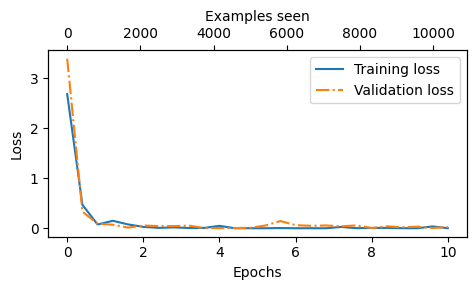

In [33]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses, label="loss")

In [34]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 100.00%
Validation accuracy: 94.63%
Test accuracy: 94.33%


In [35]:
notebook_end_time = time.time()
runtime_in_seconds = notebook_end_time - notebook_start_time

# format as minutes and seconds
minutes, seconds = divmod(runtime_in_seconds, 60)
print(f"Notebook runtime: {int(minutes)} min {seconds:.2f} sec")

Notebook runtime: 2 min 27.33 sec
